# Region selection

This is the first notebook to work through when starting an attribution study.
It is written to help evaluate the area over which the analysis will be performed.
This is mainly done through various plots.

It assumes that you have access to some gridded observational dataset at least covering the area of the event, preferably larger.

When finished it is recommended to modify the [configuration file](../config.yml) and update the values of `roi_extent`.

In [1]:
import os

import cartopy.crs as ccrs
import iris.plot as iplt
import iris.util
import iris_utils.utils
import numpy as np
import proplot as pplt
from attribution.config import init_config
from attribution.plotting import plot_regression_map
from attribution.preprocessing import load_gridclim
from attribution.utils import (
    compute_cube_regression,
    compute_index,
    compute_spatial_average,
    get_country_shape,
    get_gmst,
    select_season,
)
from climix.metadata import load_metadata
from dask.distributed import Client

/home/sm_erhol/dev/iris_utils/iris_utils/preprocessing.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
client = Client()

In [3]:
CFG = init_config()

In [4]:
variable = CFG["variable"]

The configuration need to have an observational dataset, e.g. GricClim.

In [5]:
gc_path = CFG["paths"]["data"]["gridclim"]

In [6]:
gc_path

'/nobackup/smhid17/proj/sik/SMHIGridClim_NORDIC-11/v0.9/netcdf/day/'

In [7]:
gc_cube = load_gridclim(variable=variable[0])

Let's quickly plot the entire domain of the dataset, just a random timestep.

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


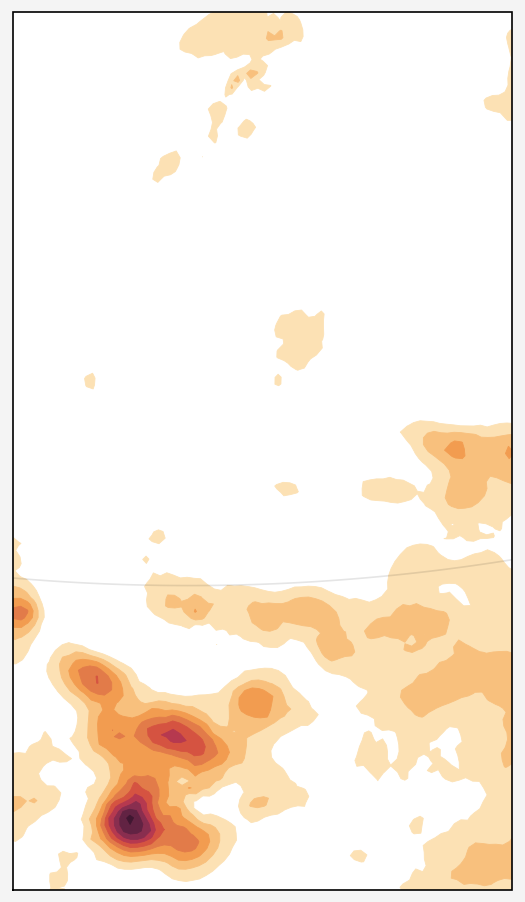

In [8]:
fig, ax = pplt.subplots(projection=ccrs.epsg(3006))
iplt.contourf(gc_cube[500, :, :], axes=ax[0]);

## Masking Sweden
Since we are working with events in Sweden, we can mask out any points that are not within the mainland.

In [9]:
# This gives us a shapefile
swe_mainland = get_country_shape()

In [10]:
# Here we create a mask (array) based on which points are within the shapefils.
mask = iris_utils.utils.mask_from_shape(
    gc_cube, swe_mainland, coord_names=("grid_latitude", "grid_longitude")
)

In [11]:
# Finally we mask the cube.
gc_cube = iris.util.mask_cube(gc_cube, mask)

Now we can plot the same timestep again and make sure that the masking worked.
We will also use the SWEREF99 projection (epsg:3006).

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


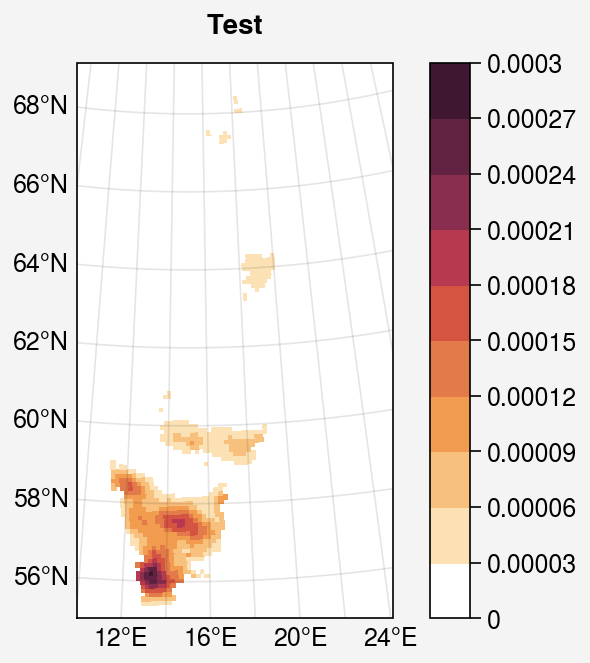

In [12]:
fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))
cm = iplt.pcolormesh(gc_cube[500], axes=ax[0])
ax.colorbar(cm)
ax.format(suptitle="Test", latlines=2, lonlines=2, lonlabels="b", latlabels="l")

We can then calculate the average summer maximum temperature over the entire dataset.
This is done to visualise the homogenity of the dataset in the region we want to select.
For other variables and types of events there could be different ways to accomplish this.

In [15]:
gc_av = gc_cube.collapsed("time", iris.analysis.MEAN)

And plot it

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


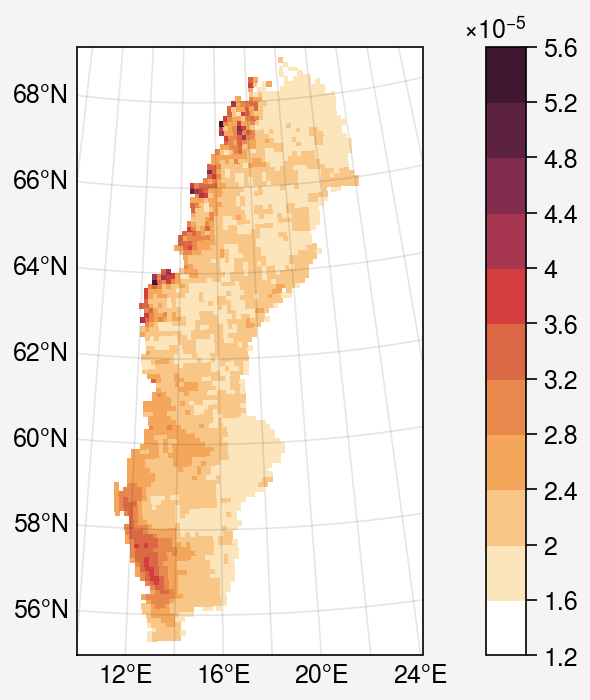

In [17]:
fig, ax = pplt.subplots(figwidth="7.5cm", projection=ccrs.epsg(3006))
cm = iplt.pcolormesh(gc_av, axes=ax[0])
cbar = ax.colorbar(cm,) # title="Temperature")
# Add gridlines.
ax.format(
    # suptitle="1971-2018 MJJA averaged daily\nmaximum near-surface\nair temperature [tasmax]",
    lonlines=2,
    latlines=2,
    lonlabels="b",
    latlabels="l",
)

## Initial region selection
Now we can start testing coordinates outlining the region of interest.
This is simplified by the helper function `region_selection` which takes a cube and a list of coordinates defining the extent: `[N, S, E, W]`.
This is the same order as the extent definition in `config.yml`.

In [13]:
from attribution.preprocessing import region_selection

Since this is an example project, `CFG["roi_extent"]` is already populated, but we will first use a list of test points anyway.

In [14]:
CFG["roi_extent"]

{'north': 63.0, 'south': 59.0, 'east': 19.5, 'west': 13.5}

Modify the values in `test_points` until region is representative of the event.

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/iris/coords.py:2047: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


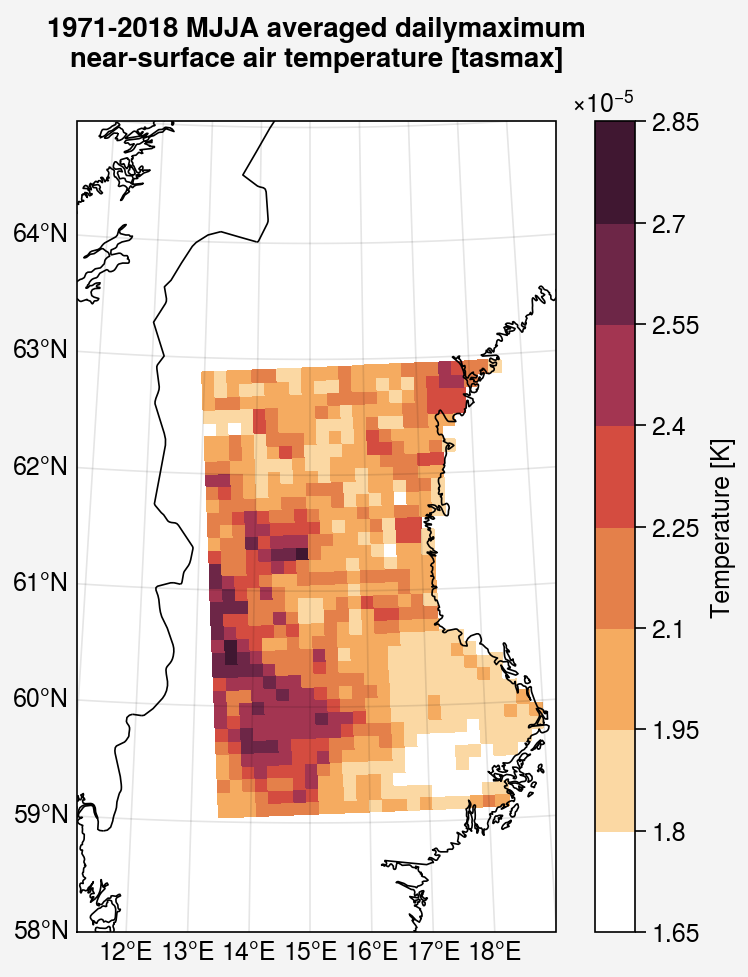

In [19]:
# These are the region extents
test_points = [63.0, 59.0, 19.0, 13.5]
# Select the region using the helper function.
test_cube = region_selection(gc_av, test_points)
# Plot it.
fig, ax = pplt.subplots(figwidth="9.5cm", projection=ccrs.epsg(3006))
cm = iplt.pcolormesh(test_cube, axes=ax[0])
# Add gridlines.
ax.set_extent((11.2, 19.0, 58.0, 65.0))
cbar = ax.colorbar(cm, title="Temperature [K]")
# Add gridlines.
ax.format(
    suptitle="1971-2018 MJJA averaged dailymaximum\nnear-surface air temperature [tasmax]",
    lonlines=1,
    latlines=1,
    lonlabels="b",
    latlabels="l",
    coast=True,
    reso="hi",
    borders=True,
)

## Region plot

In [43]:
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader

In [148]:
shp = gpd.read_file(
    shapereader.natural_earth("10m", category="cultural", name="populated_places")
)
swe_cities = shp[shp["SOV0NAME"]=="Sweden"]
cities_to_plot = swe_cities[swe_cities["NAME"].isin(["Göteborg", "Malmö","Stockholm", "Gävle", "Norrköping"])]

/home/sm_erhol/.conda/envs/erhol/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


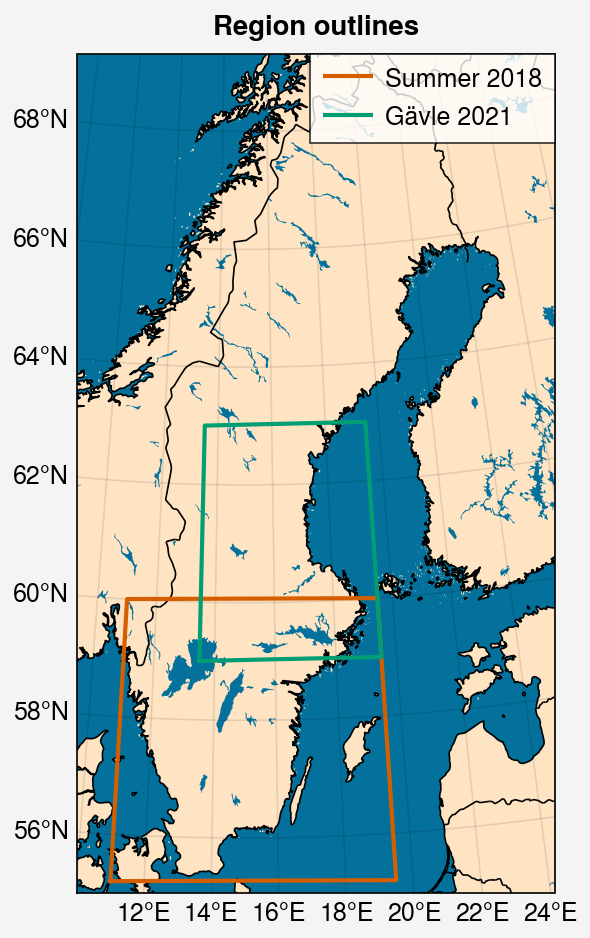

In [162]:
fig, ax = pplt.subplot(figwidth="7.5cm", proj=ccrs.epsg(3006))

ax.plot(
    [11, 19.5, 19.5, 11, 11],
    [55.2, 55.2, 60, 60, 55.2],
    color="C1",
    # linewidth=1,
    label="Summer 2018",
    zorder=4,
    transform=ccrs.PlateCarree(),
)

ax.plot(
    [13.5, 19.5, 19.5, 13.5, 13.5],
    [59.0, 59.0, 63, 63, 59.0],
    color="C2",
    # linewidth=1,
    label="Gävle 2021",
    zorder=4,
    transform=ccrs.PlateCarree(),
)

ax.legend(ncols=1)

# for _, city in cities_to_plot.iterrows():
#     loc = np.array(city.geometry.coords).squeeze()
#     # ax.scatter(*loc, c="k", zorder=5, markersize=20, transform=ccrs.PlateCarree())
#     ax.annotate(city.NAME, loc, bbox={"boxstyle": "round", "facecolor": "gray"}, transform=ccrs.PlateCarree())

ax.format(
    suptitle="Region outlines",
    lonlines=2,
    latlines=2,
    lonlabels="b",
    latlabels="l",
    coast=True,
    borders=True,
    lakes=True,
    land=True,
    landcolor="bisque",
    lakescolor="ocean blue",
    facecolor="ocean blue",
    reso="hi",
)

In [163]:
fig.save("../../plots/regions.pdf")

Save the figure.

<div class="alert alert-warning">
    <b>Remember to change the path where to save the figure!</b>
</class>

In [51]:
fig.save("../../plots/summer18_region.pdf")

Once happy with the extent, update `roi_extent` in the [configuration file](../config.yml).
The extent will be parsed automatically in functions used in preparing the different datasets.

## Regression map

The regression between GMST and the index can also be evaluated for homogenity.
However, this could be considered p-value fishing.

In [21]:
# Get the index
index_catalog, _ = load_metadata()
# Which index are we evaluating?
index_name = CFG["index_name"][0]
# index_name = "ctxge25"
index = index_catalog.prepare_indices([index_name])[0]

In [23]:
# Compute the index cube.
index_cube = compute_index(gc_cube, index, client=client)

In [ ]:
gc_cube_av = compute_spatial_average(gc_cube)
index_cube_av = compute_index(gc_cube_av, index, client=client)

In [24]:
# Get a predictor.
predictor = get_gmst(index_cube)

In [25]:
# Compute the regression in each gridpoint.
coefs, pvalues = compute_cube_regression(index_cube, predictor, broadcast_coef=False)

  0%|          | 0/163 [00:00<?, ?it/s]

Plot the regression map

In [26]:
# Create a figure/axes.
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={"projection": ccrs.epsg(3006)})
# Plot the regression map on it.
plot_regression_map(
    index_cube, index_name="rx1day", reg_coefs=coefs, pvalues=pvalues, p_lim=0.05, ax=ax
)
plt.legend();

NameError: name 'plt' is not defined

# Next step
[Prepare datasets](./2_prepare_datasets.ipynb)

In [52]:
# Shutdown the distributed client.
client.shutdown()